# Validating fine-tuned Generator via fine-tuned Classifier

In [1]:
# setup 
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import pprint
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    balanced_accuracy_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np
from tqdm import tqdm
from typing import List, Dict, Any
from datasets import Dataset, concatenate_datasets
import re
import nltk
from nltk.tokenize import sent_tokenize


# load data
generated_speeches_df = pd.read_csv("../data/generated_speeches_final_V2.csv")

# rename label CDU/CSU correctly for mapping later
generated_speeches_df["party"] = generated_speeches_df["party"].replace({
    "Union": "CDU/CSU"
})

In [4]:
# seperate dfs per model answers

all_columns_to_predict = ['speech_base_model_01', 
                          'speech_ft_model_01',
                          'speech_base_model_03', 
                          'speech_ft_model_03'] 
                          #'RAG_speech_01',
                          #'RAG_01_context_1', 
                          #'RAG_01_context_2', 
                          #'RAG_01_context_3',
                          #'RAG_speech_03']


data_dict = {}

for column in all_columns_to_predict:
    df = generated_speeches_df[["party", column]].rename(columns={"party": "label", column: "speech_text"})
    data_dict[column] = Dataset.from_pandas(df)

# save single dfs:
speech_base_model_01 = data_dict["speech_base_model_01"]
speech_ft_model_01 = data_dict["speech_ft_model_01"]
speech_base_model_03 = data_dict["speech_base_model_03"]
speech_ft_model_03 = data_dict["speech_ft_model_03"]
#RAG_speech_01 = data_dict["RAG_speech_01"]
#RAG_01_context_1 = data_dict["RAG_01_context_1"]
#RAG_01_context_2 = data_dict["RAG_01_context_2"]
#RAG_01_context_3 = data_dict["RAG_01_context_3"]
#RAG_speech_03 = data_dict["RAG_speech_03"]


# merging the original speech data into one baseline df
#baseline_real_speeches = concatenate_datasets([RAG_01_context_1, RAG_01_context_2, RAG_01_context_3])

In [ ]:
# functions to delete all party mentions
def extract_and_remove_party_mentions(speech_text, party):
    if not isinstance(speech_text, str):
        return [], speech_text

    sentences = sent_tokenize(speech_text, language='german')
    party_lower = party.lower()

    matched = [s for s in sentences if party_lower in s.lower()]
    cleaned = [s for s in sentences if party_lower not in s.lower()]

    cleaned_text = ' '.join(cleaned)
    return matched, cleaned_text


cleaned_data_dict = {}

for name, dataset in data_dict.items():
    # Convert to pandas
    df = dataset.to_pandas()

    # Apply extraction and cleaning
    matches_and_cleaned = df.apply(
        lambda row: extract_and_remove_party_mentions(row["speech_text"], row["label"]), axis=1
    )
    
    # Separate matched and cleaned
    df["matches"] = matches_and_cleaned.apply(lambda x: x[0])
    df["speech_text"] = matches_and_cleaned.apply(lambda x: x[1])

    # Convert back to Dataset data
    cleaned_data_dict[name] = Dataset.from_pandas(df)


In [ ]:
# load best classifier model
# Load model and tokenizer from local folder
model = AutoModelForSequenceClassification.from_pretrained("../data/windowmodel")
tokenizer = AutoTokenizer.from_pretrained("../data/windowmodel")


/Users/ellaalle/anaconda3/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/ellaalle/anaconda3/lib/python3.11/site-packages/torchvision/image.so, 6): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: /Users/ellaalle/anaconda3/lib/python3.11/site-packages/torchvision/image.so
  Expected in: /Users/ellaalle/anaconda3/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib
 in /Users/ellaalle/anaconda3/lib/python3.11/site-packages/torchvision/image.so'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
2025-08-05 18:21:06.266663: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To en

In [7]:
# define parameters
WINDOW_LENGTH = 512
STRIDE = 256
label_names = ['CDU/CSU', 'SPD', 'GRÜNE', 'FDP', 'AfD', 'LINKE']

In [ ]:
# define functions to tokeize test data and predict test data with fine-tuned model
model.eval()

def tokenize_sliding_windows(example: Dict[str, Any]) -> Dict[str, Any]:
    encoding = tokenizer(
        example["speech_text"],
        truncation=True,
        padding="max_length",
        max_length=WINDOW_LENGTH,
        stride=STRIDE,
        return_overflowing_tokens=True,
        return_offsets_mapping=False,
        return_tensors="pt"
    )
    return encoding

def predict_proba_for_dataset(dataset: Dataset, label_names) -> List[Dict[str, Any]]:
    results = []

    for example in tqdm(dataset):
        tokenized = tokenize_sliding_windows(example)
        input_ids = tokenized["input_ids"].to(model.device)
        attention_mask = tokenized["attention_mask"].to(model.device)

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            probs = torch.nn.functional.softmax(outputs.logits, dim=-1).cpu().numpy()

        avg_probs = probs.mean(axis=0)
        results.append({
            "probs": avg_probs.tolist(),
            "label": example["label"]  
        })

    for item in results:
      probs = item["probs"]
      pred_idx = int(np.argmax(probs))
      item["prediction_label"] = label_names[pred_idx]
    return results


In [9]:
# define function to display eval metrics
def get_metrics(true_labels, preds, model_name):
    metrics_summary = {}

    acc = accuracy_score(true_labels, preds)
    bal_acc = balanced_accuracy_score(true_labels, preds)

    precision = precision_score(true_labels, preds, average='macro', zero_division=0)
    recall = recall_score(true_labels, preds, average='macro', zero_division=0)
    f1 = f1_score(true_labels, preds, average='macro', zero_division=0)

    label_order = sorted(set(true_labels).union(set(preds)))
    report = classification_report(true_labels, preds, labels=label_order, zero_division=0)
    metrics_summary[model_name] = {
        'acc': acc,
        'bal_acc': bal_acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }
    # print metrics
    print(f"Model: {model_name}")
    print(f"  Accuracy: {acc}")
    print(f"  Balanced Accuracy: {bal_acc}")
    print(f"  Precision: {precision}")
    print(f"  Recall: {recall}")
    print(f"  F1-score: {f1}")
    print(f"  Classification Report:\n{report}")


    # Confusion Matrix
    label_order = sorted(set(true_labels).union(set(preds)))
    cm = confusion_matrix(true_labels, preds, labels=label_order)
    cm_df = pd.DataFrame(cm, index=label_order, columns=label_order)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {model_name}")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.show()


    return metrics_summary



In [10]:
# predict all generated test speeches
all_models_to_test = [speech_base_model_01, 
                        speech_ft_model_01,
                        speech_base_model_03, 
                        speech_ft_model_03]
                        # RAG_speech_01,
                        # RAG_speech_03,
                        # baseline_real_speeches]

model_names = ['speech_base_model_01', 
                'speech_ft_model_01',
                'speech_base_model_03', 
                'speech_ft_model_03'] 
                # 'RAG_speech_01',
                # 'RAG_speech_03',
                # 'baseline_real_speeches']


all_results = {}
i = 0
for dataset_to_predict in all_models_to_test:
    all_results[model_names[i]] = predict_proba_for_dataset(dataset_to_predict, sorted(label_names))
    i += 1



100%|██████████| 24/24 [03:19<00:00,  8.30s/it]


Model: speech_base_model_01
  Accuracy: 0.3333333333333333
  Balanced Accuracy: 0.3333333333333333
  Precision: 0.35833333333333334
  Recall: 0.3333333333333333
  F1-score: 0.2908730158730158
  Classification Report:
              precision    recall  f1-score   support

         AfD       0.60      0.75      0.67         4
     CDU/CSU       1.00      0.25      0.40         4
         FDP       0.25      0.25      0.25         4
       GRÜNE       0.30      0.75      0.43         4
       Linke       0.00      0.00      0.00         4
         SPD       0.00      0.00      0.00         4

    accuracy                           0.33        24
   macro avg       0.36      0.33      0.29        24
weighted avg       0.36      0.33      0.29        24



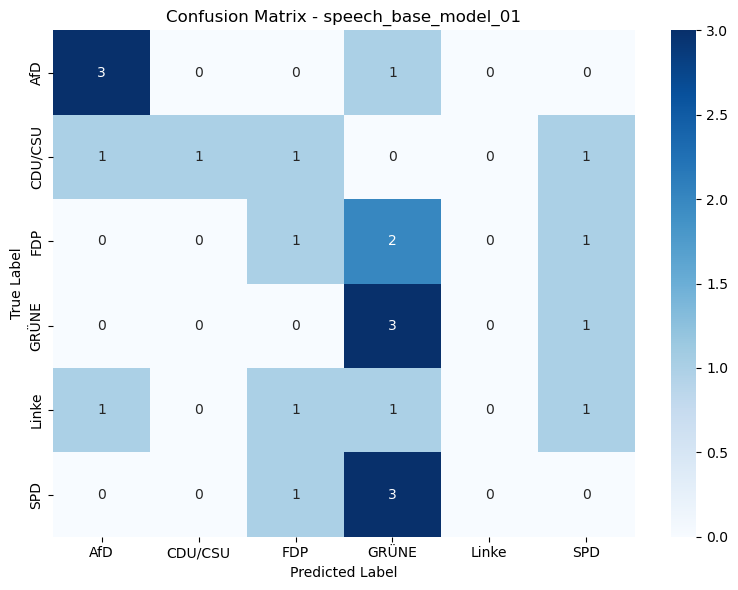

/Users/ellaalle/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Model: speech_ft_model_01
  Accuracy: 0.25
  Balanced Accuracy: 0.25
  Precision: 0.23333333333333334
  Recall: 0.21428571428571427
  F1-score: 0.17551020408163268
  Classification Report:
              precision    recall  f1-score   support

         AfD       0.30      0.75      0.43         4
     CDU/CSU       1.00      0.25      0.40         4
         FDP       0.00      0.00      0.00         4
       GRÜNE       0.33      0.50      0.40         4
       LINKE       0.00      0.00      0.00         0
       Linke       0.00      0.00      0.00         4
         SPD       0.00      0.00      0.00         4

    accuracy                           0.25        24
   macro avg       0.23      0.21      0.18        24
weighted avg       0.27      0.25      0.20        24



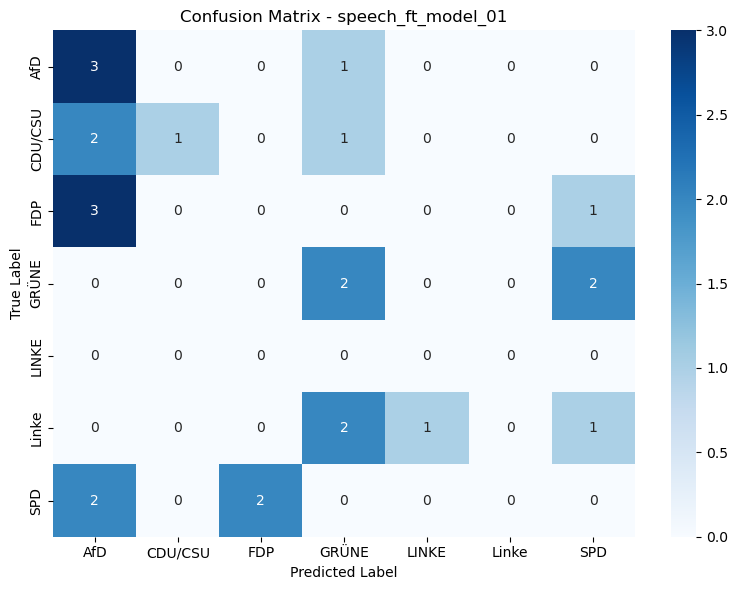

Model: speech_base_model_03
  Accuracy: 0.20833333333333334
  Balanced Accuracy: 0.20833333333333334
  Precision: 0.2777777777777778
  Recall: 0.20833333333333334
  F1-score: 0.19166666666666665
  Classification Report:
              precision    recall  f1-score   support

         AfD       1.00      0.25      0.40         4
     CDU/CSU       0.00      0.00      0.00         4
         FDP       0.50      0.50      0.50         4
       GRÜNE       0.17      0.50      0.25         4
       Linke       0.00      0.00      0.00         4
         SPD       0.00      0.00      0.00         4

    accuracy                           0.21        24
   macro avg       0.28      0.21      0.19        24
weighted avg       0.28      0.21      0.19        24



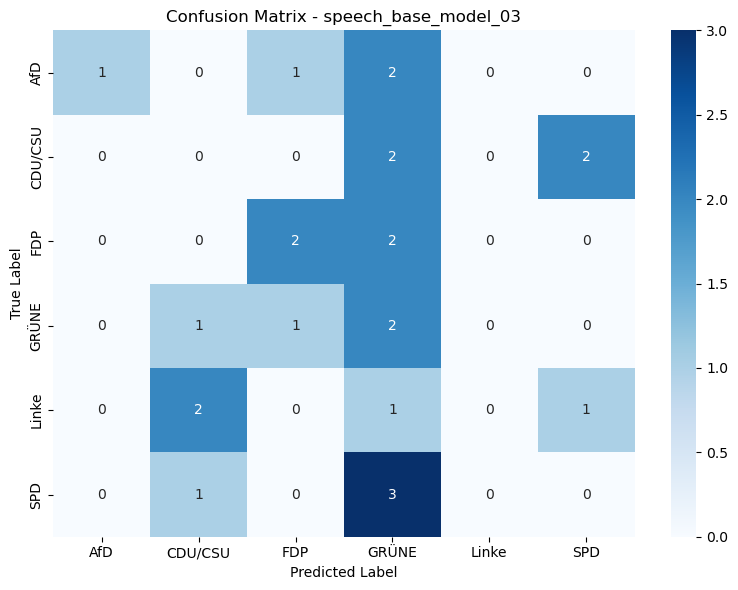

Model: speech_ft_model_03
  Accuracy: 0.20833333333333334
  Balanced Accuracy: 0.20833333333333334
  Precision: 0.13888888888888887
  Recall: 0.20833333333333334
  F1-score: 0.16025641025641024
  Classification Report:
              precision    recall  f1-score   support

         AfD       0.22      0.50      0.31         4
     CDU/CSU       0.00      0.00      0.00         4
         FDP       0.00      0.00      0.00         4
       GRÜNE       0.11      0.25      0.15         4
       Linke       0.00      0.00      0.00         4
         SPD       0.50      0.50      0.50         4

    accuracy                           0.21        24
   macro avg       0.14      0.21      0.16        24
weighted avg       0.14      0.21      0.16        24



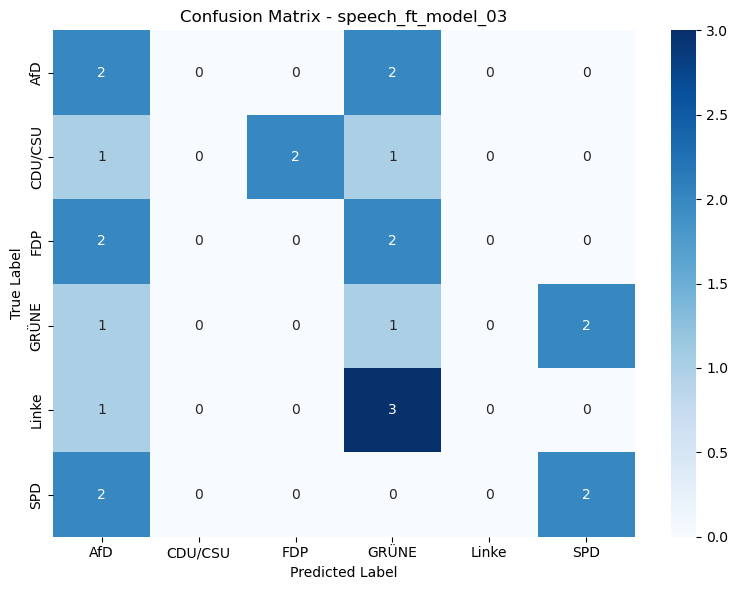

In [11]:
# run get_metrics function on all and save results 
final_performance_results = {}
i = 0

for i in range(len(model_names)):
    df = pd.DataFrame(all_results[model_names[i]])
    results =  get_metrics(df["label"], df["prediction_label"], model_names[i])
    final_performance_results.update(results)
    i += 1


In [12]:
# compare final results
final_performance_results_df = pd.DataFrame(final_performance_results)
final_performance_results_df

,speech_base_model_01,speech_ft_model_01,speech_base_model_03,speech_ft_model_03
acc,0.333333,0.250000,0.208333,0.208333
bal_acc,0.333333,0.250000,0.208333,0.208333
precision,0.358333,0.233333,0.277778,0.138889
recall,0.333333,0.214286,0.208333,0.208333
f1,0.290873,0.175510,0.191667,0.160256


In [13]:
# Visualising the results
def visualising_results(metrics_summary, results_dict = model_names):
    """Producing comprehensive visualisation that works with any number of models"""

    fig, axes = plt.subplots(2, 2, figsize=(16, 10))

    model_names = results_dict
    num_models = len(model_names)

    accuracies = [metrics_summary[name]['acc'] for name in model_names]
    balanced_accuracies = [metrics_summary[name]['bal_acc'] for name in model_names]
    precisions = [metrics_summary[name]['precision'] for name in model_names]
    recalls = [metrics_summary[name]['recall'] for name in model_names]
    f1_scores = [metrics_summary[name]['f1'] for name in model_names]

    # Subplot 1: Accuracy
    axes[0, 0].bar(np.arange(num_models) - 0.2, accuracies, width=0.4, label='Accuracy', color='skyblue')
    axes[0, 0].bar(np.arange(num_models) + 0.2, balanced_accuracies, width=0.4, label='Balanced Accuracy', color='lightgreen')
    axes[0, 0].set_title('Accuracy Comparison')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].set_xticks(np.arange(num_models))
    axes[0, 0].set_xticklabels(model_names, rotation=45)
    axes[0, 0].legend()

    # Subplot 2: Precision and Recall
    width = 0.35
    x = np.arange(num_models)
    axes[0, 1].bar(x - width/2, precisions, width, label='Precision', alpha=0.7, color='orange')
    axes[0, 1].bar(x + width/2, recalls, width, label='Recall', alpha=0.7, color='red')
    axes[0, 1].set_title('Precision and Recall')
    axes[0, 1].set_ylabel('Score')
    axes[0, 1].set_xticks(x)
    axes[0, 1].set_xticklabels(model_names, rotation=45)
    axes[0, 1].legend()

    # Subplot 3: F1
    axes[1, 0].bar(model_names, f1_scores, alpha=0.7, color='purple')
    axes[1, 0].set_title('F1 Score Comparison')
    axes[1, 0].set_ylabel('F1 Score')
    axes[1, 0].tick_params(axis='x', rotation=45)

    # Subplot 4: Overall Performance Comparison
    metrics = ['Exact Acc', 'Partial Acc', 'Precision', 'Recall', 'F1']
    for idx, name in enumerate(model_names):
        model_scores = [
            accuracies[idx],
            balanced_accuracies[idx],
            precisions[idx],
            recalls[idx],
            f1_scores[idx],
        ]
        marker = ['o', 's', '^', 'D', 'x'][idx % 5]  # Use different markers
        axes[1, 1].plot(metrics, model_scores, marker + '-', label=name, linewidth=2, markersize=8)

    axes[1, 1].set_title('Overall Performance Comparison')
    axes[1, 1].set_ylabel('Score')
    axes[1, 1].legend()
    axes[1, 1].tick_params(axis='x', rotation=45)
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


In [14]:
model_names

['speech_base_model_01',
 'speech_ft_model_01',
 'speech_base_model_03',
 'speech_ft_model_03']

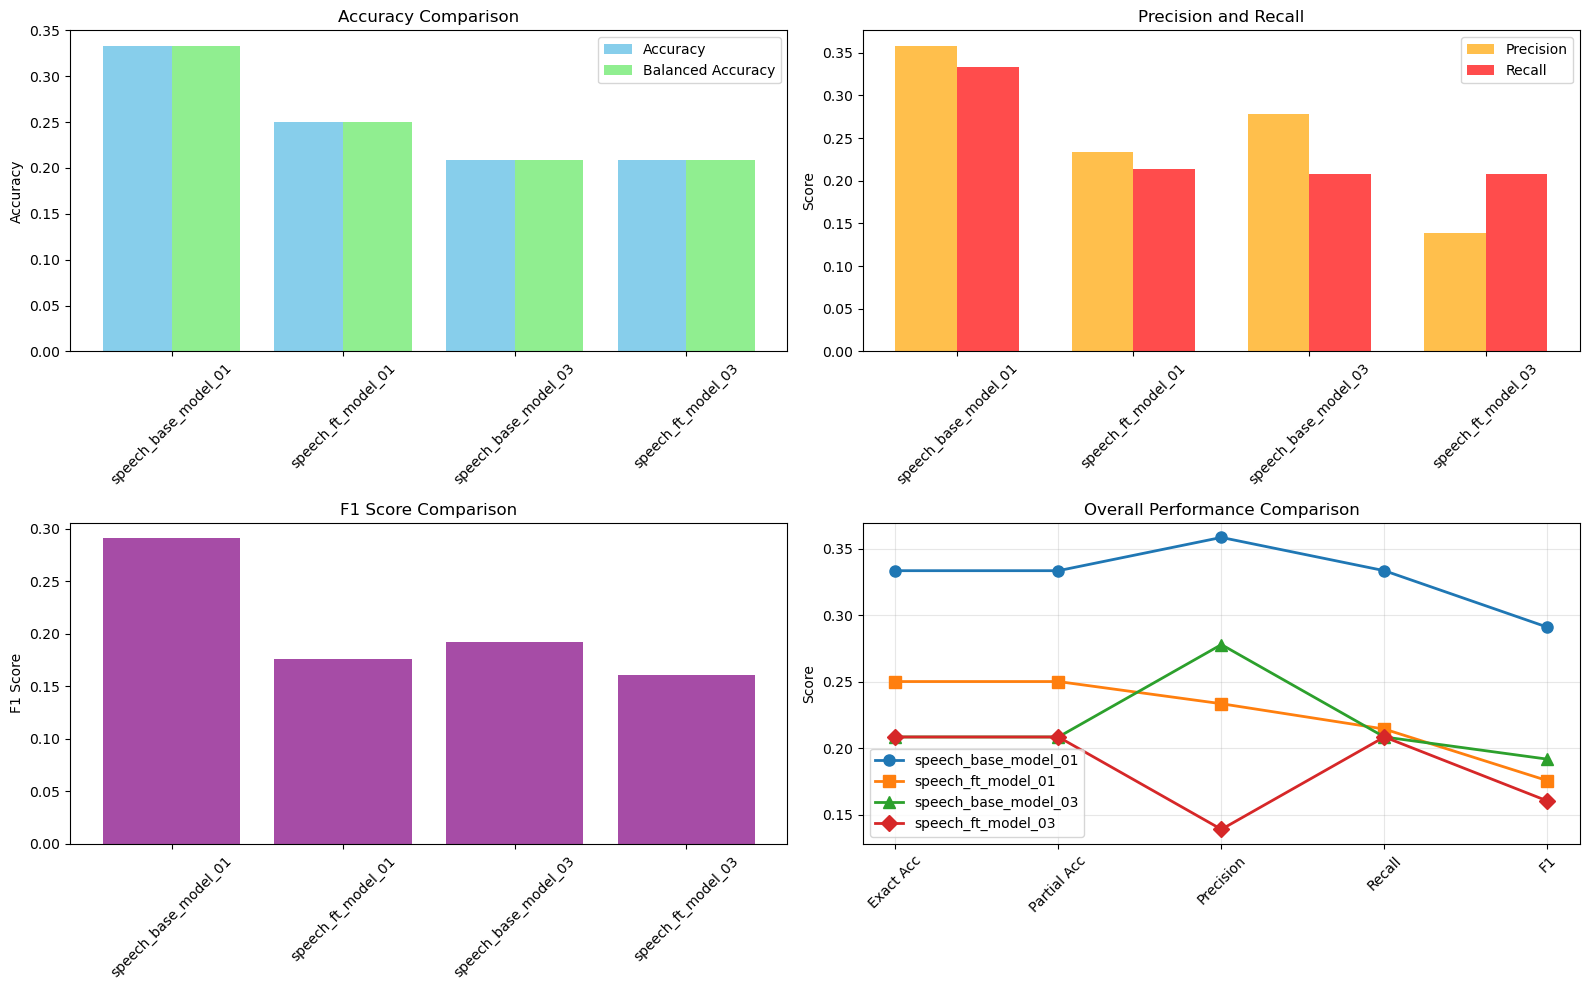

In [15]:
visualising_results(final_performance_results, results_dict = model_names)